# NO positional Embedding 10 trials

## Package Installation

In [1]:
import os
import sys

# Path

In [2]:
print(os.getcwd())

C:\Users\Administrator\Desktop\trails10\experiment_1_10trials


In [3]:
training_data_kok14_galfa = os.path.join(os.getcwd(),"data", "other", "training_data_kok14_galfa.pickle")

## Libraries

In [4]:

from __future__ import print_function, division
from astropy.io          import fits
from astropy             import units as u
from astropy.coordinates import SkyCoord

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import OrderedDict
import math

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from torchsummary import summary
from torchvision import datasets
from torch.optim.lr_scheduler import LambdaLR, StepLR, MultiStepLR, ExponentialLR
import os
import argparse

import glob
import pickle

C:\Users\Administrator\.conda\envs\torch1.12.1\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data preparation

In [5]:
data = pickle.load(open(training_data_kok14_galfa, 'rb'))

# training data
X_train = data['X_train']
Y_train = data['Y_train']
# Observed test data
X_test = data['X_test']
Y_test = data['Y_test']

## Split train, validation and testing set from X_train and Y_train. (60%, 20%, 20%)

In [6]:
# set aside 20% of train and test data for evaluation
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.2, shuffle = True, random_state = 8)

# Use the same function above for the validation set
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2

In [7]:
print("x_train=",x_train.shape, ", y_train=", y_train.shape)
print("x_val=",x_val.shape, ", y_val=", y_val.shape)
print("x_test=",x_test.shape, ", y_test=", y_test.shape)

x_train= (23268, 414) , y_train= (23268, 2)
x_val= (7756, 414) , y_val= (7756, 2)
x_test= (7757, 414) , y_test= (7757, 2)


## Plot a few training samples

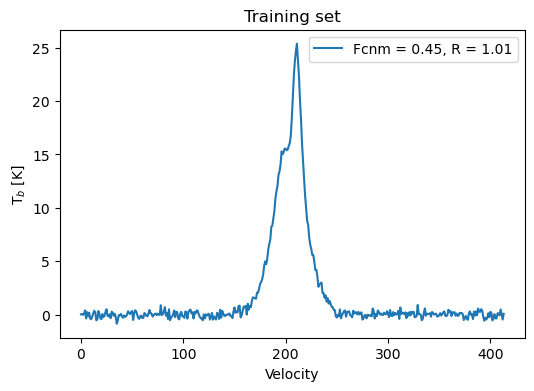

In [8]:
# Spectrum in training set
plt.figure(figsize=(6,4))
plt.plot(X_train[0, :], label=f'Fcnm = {round(Y_train[20000,0], 2)}, R = {round(Y_train[0,1], 2)}')

plt.title('Training set')
plt.xlabel('Velocity')
plt.ylabel('T$_b$ [K]')
plt.legend()
plt.show()

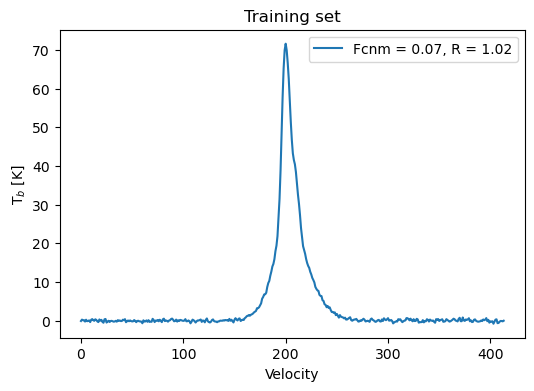

In [9]:
# Spectrum in training set
plt.figure(figsize=(6,4))
plt.plot(X_train[1000, :], label=f'Fcnm = {round(Y_train[10000,0], 2)}, R = {round(Y_train[10000,1], 2)}')

plt.title('Training set')
plt.xlabel('Velocity')
plt.ylabel('T$_b$ [K]')

plt.legend()

plt.show()

## Data loader

In [10]:
# data loader 
class HI_dataset(torch.utils.data.Dataset):
    def __init__(self, x, y, transform=None, target_transform=None):
        
        self.x = x
        self.y = y
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.y[:,0])
    
    def __getitem__(self, idx):
        spectra = self.x[idx,:]
        label = self.y[idx,:]
        if self.transform:
            spectra = self.transform(spectra)
            spectra = spectra.reshape(1, spectra.shape[0])
        if self.target_transform:
            label = self.target_transform(label)
        return spectra, label

In [11]:
# transform to tenor 
class ToTensor_x():
    def __call__(self, sample):
        x = torch.from_numpy(sample)
        return x

In [12]:
# transform to tenor 
class ToTensor_y():
    def __call__(self, sample):
        x = torch.from_numpy(sample)
        return x

In [13]:
# initialize dataset
dataset_train = HI_dataset(x_train, y_train,transform=ToTensor_x(), target_transform=ToTensor_y())
dataset_val = HI_dataset(x_val, y_val,transform=ToTensor_x(), target_transform=ToTensor_y())
dataset_test = HI_dataset(x_test, y_test,transform=ToTensor_x(), target_transform=ToTensor_y())

In [14]:
# initialize data loader
batch_size = 20 
train_loader = torch.utils.data.DataLoader(dataset = dataset_train, batch_size = batch_size, shuffle =True)
valid_loader = torch.utils.data.DataLoader(dataset = dataset_val, batch_size = batch_size, shuffle =False)
test_loader = torch.utils.data.DataLoader(dataset = dataset_test, batch_size = batch_size, shuffle =False)

In [15]:
# test data loader
val = iter(test_loader)
A,B = next(val)
print(A.shape)
print(B.shape)

torch.Size([20, 1, 414])
torch.Size([20, 2])


## CNN Model

In [17]:
import math
class Net_origin_deep(nn.Module):
    def __init__(self, num_output=2, in_channels=1, num_output_1=72, num_output_2=64, num_output_3=56, num_output_4=48):
        super(Net_origin_deep, self).__init__()
        # layers
        self.conv1 = nn.Conv1d(in_channels = in_channels, out_channels=num_output_1, 
                               kernel_size=6, stride=1, padding=0, bias=True, padding_mode='zeros')
        
        self.bn1 = nn.BatchNorm1d(num_output_1)
        
        self.conv2 = nn.Conv1d(in_channels= num_output_1, out_channels=num_output_2,
                               kernel_size=40, stride=1, padding=0, bias=True, padding_mode='zeros')
        
        self.bn2 = nn.BatchNorm1d(num_output_2)
            
        self.conv3 = nn.Conv1d(in_channels = num_output_2, out_channels=num_output_3, 
                               kernel_size=6, stride=1, padding=0, bias=True, padding_mode='zeros')
        
        self.bn3 = nn.BatchNorm1d(num_output_3)
        self.conv4 = nn.Conv1d(in_channels= num_output_3, out_channels=num_output_4,
                               kernel_size=40, stride=1, padding=0, bias=True, padding_mode='zeros')
        
        self.bn4 = nn.BatchNorm1d(num_output_4)
        
        self.conv5 = nn.Conv1d(in_channels = num_output_4, out_channels=40, 
                               kernel_size=6, stride=1, padding=0, bias=True, padding_mode='zeros')
        
        self.bn5 = nn.BatchNorm1d(40)
        
        self.conv6 = nn.Conv1d(in_channels= 40, out_channels=32, kernel_size=40, 
                               stride=1, padding=0, bias=True, padding_mode='zeros')
        
        self.bn6 = nn.BatchNorm1d(32)
        
        self.conv7 = nn.Conv1d(in_channels = 32, out_channels=16, kernel_size=6,
                               stride=1, padding=0, bias=True, padding_mode='zeros')
        
        self.bn7 = nn.BatchNorm1d(16)
        
        self.conv8 = nn.Conv1d(in_channels= 16, out_channels=8, kernel_size=40, 
                               stride=1, padding=0, bias=True, padding_mode='zeros')
        
        self.bn8 = nn.BatchNorm1d(8)
        
        self.dropout = nn.Dropout(0.30)

        self.linear = nn.Linear(1904, num_output)
        self.flatten = nn.Flatten()

        # init parameter
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                n = m.kernel_size[0]*m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()

    def forward(self, x):
        #print(1, x.size())
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        #x = self.dropout0(x)
        #print(2, x.size())
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        #print(3, x.size())
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        #x = self.dropout0(x)
        #
        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        #
        x = self.conv5(x)
        x = self.bn5(x)
        x = F.relu(x)
        #
        x = self.conv6(x)
        x = self.bn6(x)
        x = F.relu(x)
        #
        x = self.conv7(x)
        x = self.bn7(x)
        x = F.relu(x)
        #
        x = self.conv8(x)
        x = self.bn8(x)
        x = F.relu(x)
        #
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.linear(x)
        #print(4, x.size())
        return x

## Model Training and Evaluation 

In [18]:
# train 
def train(epoch):
    model.train()
    train_loss = 0
    total = 0
    for index, (inputs, values) in enumerate(train_loader):
        inputs = inputs.float()
        values = values.float()
        inputs, values = inputs.to(device), values.to(device)
        # forward
        outputs = model(inputs)
        loss = loss_function(outputs, values)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # print info
        train_loss = train_loss + (loss.item()*values.size(0)) 
        total += values.size(0)
    print("total loss=",train_loss)
    return train_loss/total

In [21]:
def validation(epoch):
    model.eval()
    global best_err
    test_loss = 0
    total = 0
    with torch.no_grad():
        for index, (inputs, values) in enumerate(valid_loader):
            inputs = inputs.float()
            values = values.float()
            inputs, values = inputs.to(device), values.to(device)
            # forward
            outputs = model(inputs)
            loss = loss_function(outputs, values)
            test_loss = test_loss + (loss.item()*values.size(0))
            total += values.size(0)
    # Save checkpoint.
    error =  test_loss / total
    print(f"validation MSE in epoch {epoch}= ", error)
    if error < best_err:
        print('best_err:', error, 'Saving..')
        state = {'net': model.state_dict(),
                 'err': error,
                 'optimizer_state_dict': optimizer.state_dict(),
                 'epoch': epoch}
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/no_pe_s2.pth')
        best_err = error
    return error

In [28]:
def test(epoch):
    model.eval()
    global best_err
    test_loss = 0
    total = 0
    with torch.no_grad():
        for index, (inputs, values) in enumerate(test_loader):
            inputs = inputs.float()
            values = values.float()
            inputs, values = inputs.to(device), values.to(device)
            # forward 
            outputs = model(inputs)
            #outputs = outputs.view(outputs[0], 1, outputs[1])
            loss = loss_function(outputs, values)
            test_loss =test_loss+ (loss.item()* values.size(0))
            total += values.size(0)
        #print(f'Test performance in epoch {epoch}: avg_error = {test_loss/total}')
        return test_loss/total

## Start 10 trail Training

In [29]:
# define number of trails, number of epoch and learning rate
num_trial = 10
num_epoch = 80
learning_rate = 0.005
# the savier of best validation performance and coresponding testing performance.
vali = []
testing = []
# saver for each trials
train_trails = []
validate_trails =[]
test_trails = []

In [30]:
def trail(num_epoch):
    global vali
    global testing
    global scheduler
    global model
    global lr
    #define savor
    global train_trails
    global validate_trails
    global test_trails
    for epoch in range(num_epoch):
        train_err = train(epoch)
        vali_err = validation(epoch)
        scheduler.step()
        test_err = test(epoch)
        # save data
        train_trails.append(train_err)
        validate_trails.append(vali_err)
        test_trails.append(test_err)
    # final test
    validation_error,test_error = validate_model()
    print("test err=",test_error)
    vali.append(validation_error)
    testing.append(test_error)

In [31]:
def validate_model():
    global model
    model = Net_origin_deep()
    num_step = len(X_train)/batch_size
    loss_function = nn.MSELoss()
    best_err = 100000
    checkpoint = torch.load('./checkpoint/no_pe_s2.pth',map_location=torch.device('cuda:0'))
    model.load_state_dict(checkpoint['net'])
    model.to(device)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    validation_error = validation(epoch)
    test_error = test(epoch)
    return validation_error, test_error

In [32]:
# start 10 trails.
for i in range (0, num_trial):
    print(f'start the {i}th trial:')
    # model initialization
    lr=learning_rate
    model = Net_origin_deep()
    num_step = len(X_train)/batch_size
    loss_function = nn.MSELoss()
    best_err = 100000
    optimizer = torch.optim.SGD(model.parameters(), lr)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizer, 
                                                     milestones = [65], 
                                                     gamma=0.1, last_epoch=-1, 
                                                     verbose=False)
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    trail(num_epoch)

start the 0th trial:
total loss= 843.4029940068722
validation MSE in epoch 0=  0.009145724632351719
best_err: 0.009145724632351719 Saving..
total loss= 400.84387723729014
validation MSE in epoch 1=  0.008349627628093926
best_err: 0.008349627628093926 Saving..
total loss= 336.1540947314352
validation MSE in epoch 2=  0.008288223909040266
best_err: 0.008288223909040266 Saving..
total loss= 287.62225206103176
validation MSE in epoch 3=  0.00908290430345794
total loss= 262.1369649162516
validation MSE in epoch 4=  0.008032835097886217
best_err: 0.008032835097886217 Saving..
total loss= 245.40286519005895
validation MSE in epoch 5=  0.008509396383867374
total loss= 236.08004189934582
validation MSE in epoch 6=  0.007639876197228163
best_err: 0.007639876197228163 Saving..
total loss= 223.65789244277403
validation MSE in epoch 7=  0.0074618866987398655
best_err: 0.0074618866987398655 Saving..
total loss= 219.66551538044587
validation MSE in epoch 8=  0.00725575901765824
best_err: 0.0072557590

# plot traing process

## plot the training and validation and testing chart

In [33]:
def plott(x, ti):
    plt.figure(figsize=(7,5))
    index = 0
    for i in range(0, 9):
        t = x[index: index+80]
        index=index+80
        plt.plot(t, label=f'trail {i}')
    plt.title(f'{ti} MSE in different trails')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid()

In [34]:
def plott_20(x, ti):
    plt.figure(figsize=(7,5))
    index = 0
    for i in range(0, 9):
        t = x[index+59: index+80]
        index=index+80
        plt.plot(t, label=f'trail {i}')
    plt.title(f'{ti} MSE in different trails(last 20 epoch)')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid()
    plt.show()

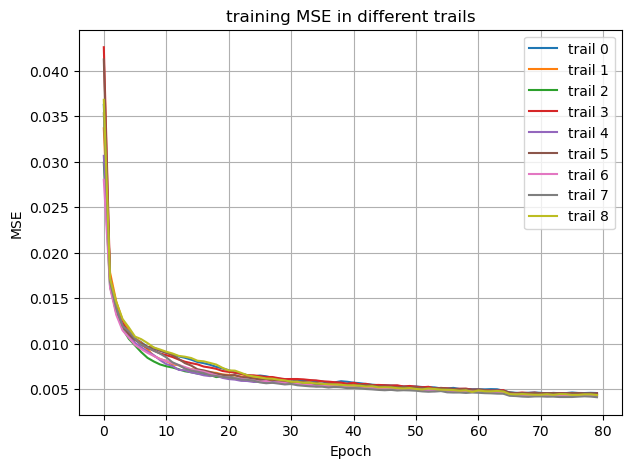

In [35]:
# training 
x = np.array(train_trails)
plott(x, "training")

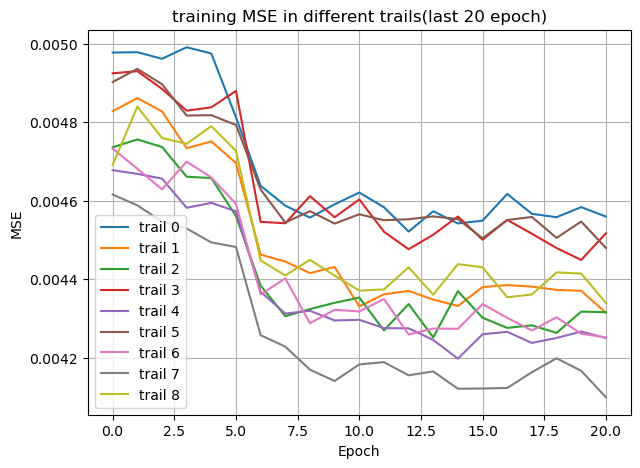

In [36]:
# training 
x = np.array(train_trails)
plott_20(x, "training")

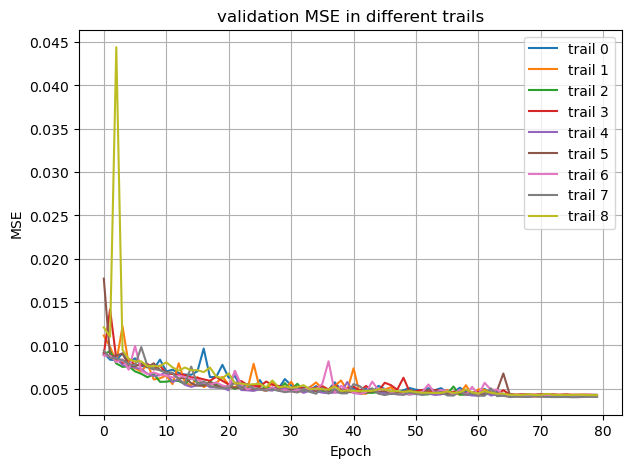

In [37]:
# validation
x = np.array(validate_trails)
plott(x, "validation")

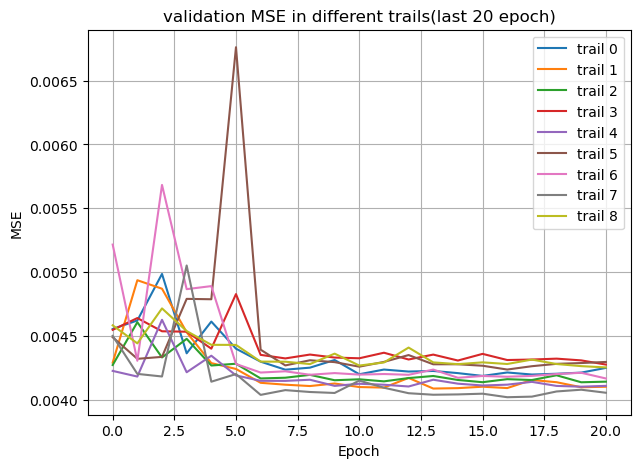

In [38]:
# validation
x = np.array(validate_trails)
plott_20(x, "validation")

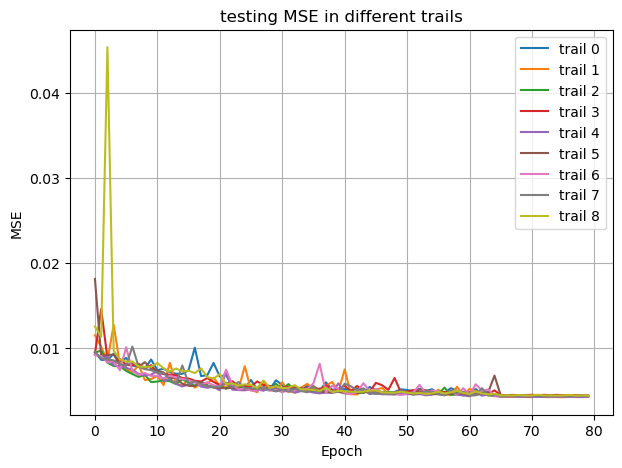

In [39]:
# testing 
x = np.array(test_trails)
plott(x, "testing")

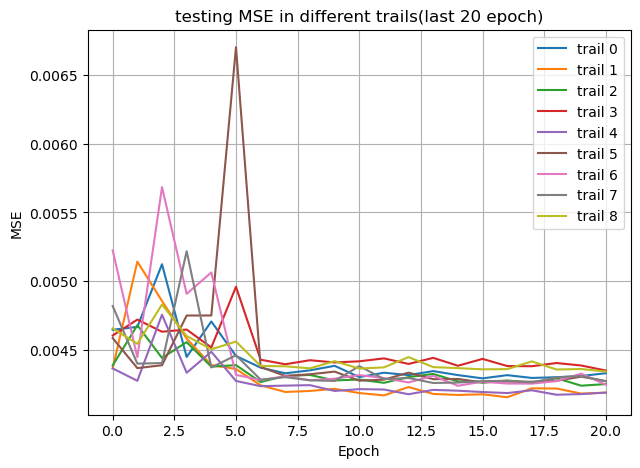

In [40]:
# testng
x =  np.array(test_trails)
plott_20(x, "testing")

## plot the best velidation MSE and testing MSE

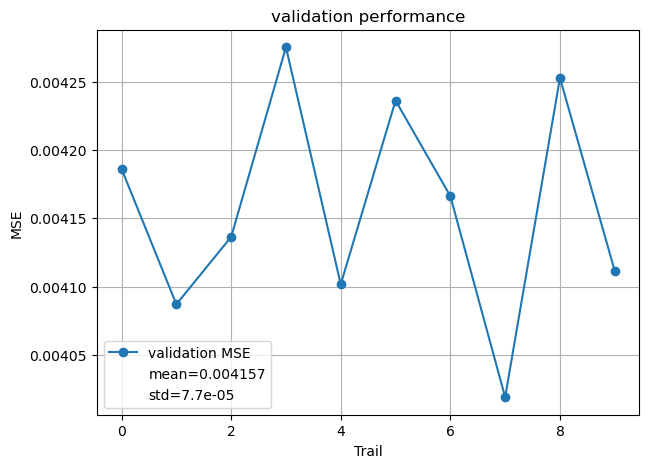

validation mean= 0.004157218737639701
validation std= 7.725512628398918e-05


In [41]:
x = vali
plt.figure(figsize=(7,5))
plt.title('validation performance')
plt.plot(x, label='validation MSE',marker='o')
plt.plot([], [], ' ', label=f"mean={round(np.mean(x),6)}")
plt.plot([], [], ' ', label=f"std={round(np.std(x),6)}")
plt.xlabel('Trail')
plt.ylabel('MSE')
plt.legend()
plt.grid()
plt.show()
print("validation mean=",np.mean(x))
print("validation std=",np.std(x))

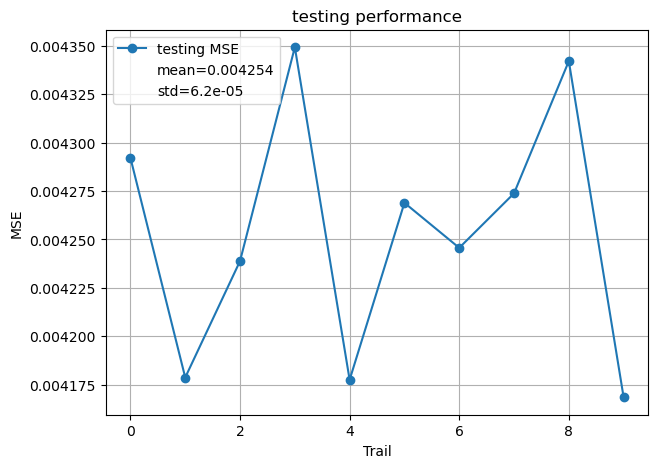

testing mean= 0.004253552019642263
testing std= 6.162897160004693e-05


In [42]:
x = testing
plt.figure(figsize=(7,5))
plt.title('testing performance')
plt.plot(x, label='testing MSE',marker='o')
plt.plot([], [], ' ', label=f"mean={round(np.mean(x),6)}")
plt.plot([], [], ' ', label=f"std={round(np.std(x),6)}")
plt.xlabel('Trail')
plt.ylabel('MSE')
plt.legend()
plt.grid()
plt.show()
print("testing mean=",np.mean(x))
print("testing std=",np.std(x))

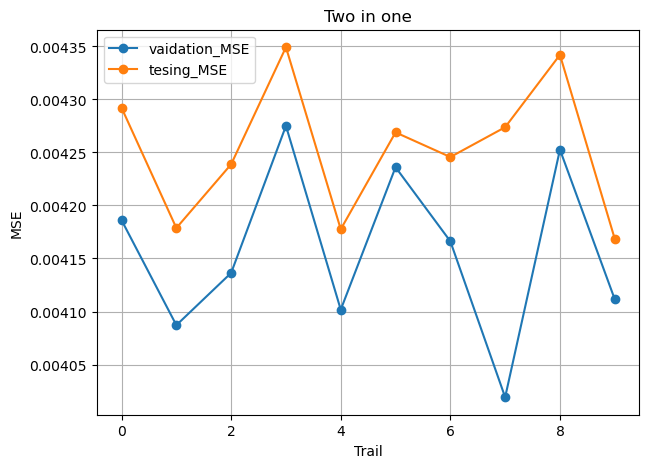

In [43]:
x1 = vali
x2 = testing
plt.figure(figsize=(7,5))
plt.title('Two in one')
plt.plot(x1, label='vaidation_MSE',marker='o')
plt.plot(x2, label='tesing_MSE',marker='o')
plt.xlabel('Trail')
plt.ylabel('MSE')
plt.legend()
plt.grid()
plt.show()

## Save csv

In [44]:
x1 = np.array(vali).reshape(1, -1)
x2 = np.array(testing).reshape(1, -1)
two = np.vstack((x1,x2))
df = pd.DataFrame(two).T
df.to_csv(os.path.join(os.getcwd(),"training_process") + "\\no_pe_s2.csv")

In [45]:
# save data 
x1 = np.array(train_trails).reshape(1, -1)
x2 = np.array(validate_trails).reshape(1, -1)
x3 = np.array(test_trails).reshape(1, -1)
three = np.vstack((x1,x2,x3))
df = pd.DataFrame(three).T
df.to_csv(os.path.join(os.getcwd(),"training_process") + "\\no_pe_whole_s2.csv")